# Density-PINN for $n$-Dimensional Fokker-Planck Equations

**Author:** Bilal Saleh Husain  

---

We develop a Physics-Informed Neural Network (PINN) framework for solving the $n$-dimensional Fokker-Planck equation arising from geometric Brownian motion in log-space. This corresponds to the asset dynamics in the Merton structural model. 

The PINN learns the probability density by minimizing an objective function comprising: $(i)$ the Fokker-Planck PDE residual, $(ii)$ initial condition loss, and $(iii)$ the density normalization constraint. We validate against analytical Gaussian solutions and have set up the notebook to allow for testing in higher dimensions. Additionally, we compute the Stein score function for future use in score-based diffusion models.

## Setup and Imports

In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn as nn

sys.path.insert(0, str(Path.cwd().parent / 'src'))

from pinn_sgm.equations import FokkerPlanckMertonND
from pinn_sgm.nets import MLP, DGM, DensityNetwork
from pinn_sgm.solvers import PINNSolver
from pinn_sgm.visualizations import (
    plot_training_history,
    plot_density_evolution,
    plot_score_field,
    plot_score_magnitude_analysis,
    plot_error_analysis,
    setup_publication_style
)
from pinn_sgm.utils import ScoreExtractor
from pinn_sgm.config import PINNConfig, TrainingConfig

setup_publication_style()
%config InlineBackend.figure_format = 'retina'

In [2]:
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## Part 1: Mathematical Framework

### 1.1 Problem Formulation

**Geometric Brownian Motion**: Asset value $V_t$ follows:
$$
dV_t = \mu V_t dt + \sigma V_t dW_t
$$
where $\mu$ is the drift, $\sigma$ is the volatility, and $W_t$ is standard Brownian motion.

**Log-Space Transformation**: Transform to log-returns $X_t = \ln V_t$. By Itô's lemma:
$$
dX_t^{(i)} = \alpha_i dt + \sigma_i dW_t^{(i)}, \quad \alpha_i = \mu_i - \frac{\sigma_i^2}{2}
$$

In vector form: $dX_t = \alpha dt + \Sigma dW_t$ where $X_t \in \mathbb{R}^n$, $\alpha \in \mathbb{R}^n$, and $\Sigma \in \mathbb{R}^{n \times n}$.

**Fokker-Planck Equation**: The density $p(x, t)$ evolves as:
$$
\frac{\partial p}{\partial t} + \sum_{i=1}^n \alpha_i \frac{\partial p}{\partial x_i} - \frac{1}{2}\sum_{i,j=1}^n D_{ij} \frac{\partial^2 p}{\partial x_i \partial x_j} = 0
$$
where $D = \Sigma\Sigma^\top$.

**Initial condition**: $p(x, 0) = \delta(x - x_0)$  
**Analytical solution**: $p(x, t) = \mathcal{N}(x \mid x_0 + \alpha t, Dt)$  
**Score function**: $s(x, t) = \nabla_x \log p(x, t) = -\frac{1}{t}D^{-1}(x - x_0 - \alpha t)$

## Part 2: PINN Implementation

### 2.1 Equation Configuration

We configure an $n$-dimensional system. The dimension `spatial_dim` can be adjusted to solve higher-dimensional problems.

In [3]:
# Spatial dimension 
spatial_dim = 1

# Auto-generate drift and diffusion parameters
mu = np.linspace(0.05, 0.1, spatial_dim)      # Drift: 5% to 10% across factors
sigma = np.linspace(0.2, 0.3, spatial_dim)    # Volatility: 15% to 30% across factors

# Initial position (start at origin in log-space)
x0 = np.zeros(spatial_dim)

# Domain bounds
x_min, x_max = -1.0, 1.0
t_max = 1.0               

# Create Fokker-Planck equation
equation = FokkerPlanckMertonND(
    spatial_dim=spatial_dim,
    mu=mu,
    sigma=sigma,
    x0=x0,
    device=device
)

# Display configuration
print(f"Configuration:")
print(f"  Dimension: {spatial_dim}D")
print(f"  Drift μ: {mu}")
print(f"  Diffusion σ: {sigma}")
print(f"  Domain: x ∈ [{x_min}, {x_max}]^{spatial_dim}, t ∈ [0, {t_max}]")
print(f"\nDiffusion matrix D = (1/2)ΣΣᵀ:")
print(equation.D.cpu().numpy())
print(f"\nAnalytical solution: p(x,t) = N(x | x₀ + αt, 2tD)")
print(f"where α = μ - σ²/2")

Configuration:
  Dimension: 1D
  Drift μ: [0.05]
  Diffusion σ: [0.2]
  Domain: x ∈ [-1.0, 1.0]^1, t ∈ [0, 1.0]

Diffusion matrix D = (1/2)ΣΣᵀ:
[[0.04]]

Analytical solution: p(x,t) = N(x | x₀ + αt, 2tD)
where α = μ - σ²/2


### 2.2 PINN Architecture & Loss Function

The network approximates the density $p(x, t)$ using a flexible architecture:

**DensityNetwork Wrapper**:
- Wraps any base network (MLP, DGM, or custom) to ensure positive outputs
- **Input**: Concatenated $[x_1, \ldots, x_n, t] \in \mathbb{R}^{n+1}$
- **Base architectures**: 
  - MLP: Standard multi-layer perceptron with $\tanh$ activations
  - DGM: Deep Galerkin Method with LSTM-like gating 
- **Output Activation**: $\text{Softplus}(z) = \log(1 + e^z)$ ensures $p > 0$

**Loss Function**:
$$
\mathcal{L}(\theta) = \lambda_{\text{PDE}} \frac{1}{N_{\text{col}}} \sum_{i} |\mathcal{F}[p_\theta](x_i, t_i)|^2 + \lambda_{\text{IC}} \frac{1}{N_{\text{IC}}} \sum_{j} |p_\theta(x_j, 0) - \delta(x_j - x_0)|^2 + \lambda_{\text{norm}} \left| \int p_\theta \, dx - 1 \right|^2
$$

where $\mathcal{F}$ is the Fokker-Planck operator.

In [4]:
# Option 1: DensityNetwork with MLP base (standard)
base = MLP(
    input_dim=spatial_dim + 1,  # Concatenated (x, t)
    output_dim=1,               # Scalar output before Softplus
    hidden_dims=[64, 64, 64],
    activation='tanh'
).to(device)
network = DensityNetwork(base, spatial_dim=spatial_dim).to(device)

'''
# Option 2: DensityNetwork with DGM base (for high dimensions)
base = DGM(
    input_dim=spatial_dim + 1,  # Concatenated (x, t)
    output_dim=1,               # Scalar output before Softplus
    hidden_dims=[25, 25, 25],
    activation='tanh'
).to(device)
network = DensityNetwork(base, spatial_dim=spatial_dim).to(device)
'''

n_params = sum(p.numel() for p in network.parameters())
print(f"Network: {network}")
print(f"Parameters: {n_params:,}")

Network: DensityNetwork(base=MLP, output=Softplus, spatial_dim=1)
Parameters: 8,577


In [5]:
# PINN solver configuration
pinn_config = PINNConfig(
    x_range=(x_min, x_max),
    t_range=(0.0, t_max),
    num_collocation=5000,
    num_initial=2000,
    num_boundary=0,
    device=str(device),
    enforce_normalization=True,
    pde_weight=1.0,          
    ic_weight=1.0,           
    normalization_weight=0.5
)

training_config = TrainingConfig(
    batch_size=1000,
    epochs=8000,
    learning_rate=1e-3,
    lr_scheduler='step',
    lr_decay_step=3000,
    lr_decay_rate=0.5,
    optimizer='adam',
    weight_decay=1e-6,
    gradient_clip_val=1.0,
    verbose=True,
    log_interval=250
)

solver = PINNSolver(
    equation=equation,
    network=network,
    pinn_config=pinn_config,
    training_config=training_config
)

print(f"\nSolver Configuration:")
print(f"  Spatial domain: x ∈ {pinn_config.x_range}")
print(f"  Time domain: t ∈ {pinn_config.t_range}")
print(f"  Collocation points: PDE={pinn_config.num_collocation:,}, IC={pinn_config.num_initial:,}")
print(f"  Loss weights: λ_PDE={pinn_config.pde_weight}, λ_IC={pinn_config.ic_weight}, λ_norm={pinn_config.normalization_weight}")
print(f"  Training: {training_config.epochs:,} epochs, LR={training_config.learning_rate}")


Solver Configuration:
  Spatial domain: x ∈ (-1.0, 1.0)
  Time domain: t ∈ (0.0, 1.0)
  Collocation points: PDE=5,000, IC=2,000
  Loss weights: λ_PDE=1.0, λ_IC=1.0, λ_norm=0.5
  Training: 8,000 epochs, LR=0.001


### 2.3 Training

In [6]:
results = solver.train()
history = results['history']


Epoch        Loss         PDE          IC           BC           LR           Time        
------------------------------------------------------------------------------------
0/8000       1.6328e+01   7.0941e-03   1.6276e+01   0.0000e+00   1.0000e-03   15.90it/s   
250/8000     1.1281e+01   2.4585e-01   1.1015e+01   0.0000e+00   1.0000e-03   73.34it/s   
500/8000     5.8027e+00   1.4521e-01   5.6485e+00   0.0000e+00   1.0000e-03   77.12it/s   
750/8000     6.6237e+00   1.7030e-01   6.4417e+00   0.0000e+00   1.0000e-03   78.68it/s   
1000/8000    7.9160e+00   6.9614e-01   7.2148e+00   0.0000e+00   1.0000e-03   79.37it/s   
1250/8000    6.8628e+00   7.7587e-01   6.0837e+00   0.0000e+00   1.0000e-03   76.42it/s   
1500/8000    6.8803e+00   6.3595e-01   6.2358e+00   0.0000e+00   1.0000e-03   71.37it/s   
1750/8000    7.7963e+00   3.1703e+00   4.6244e+00   0.0000e+00   1.0000e-03   71.79it/s   
2000/8000    3.5759e+00   4.3338e-01   3.1197e+00   0.0000e+00   1.0000e-03   72.21it/s   
2250

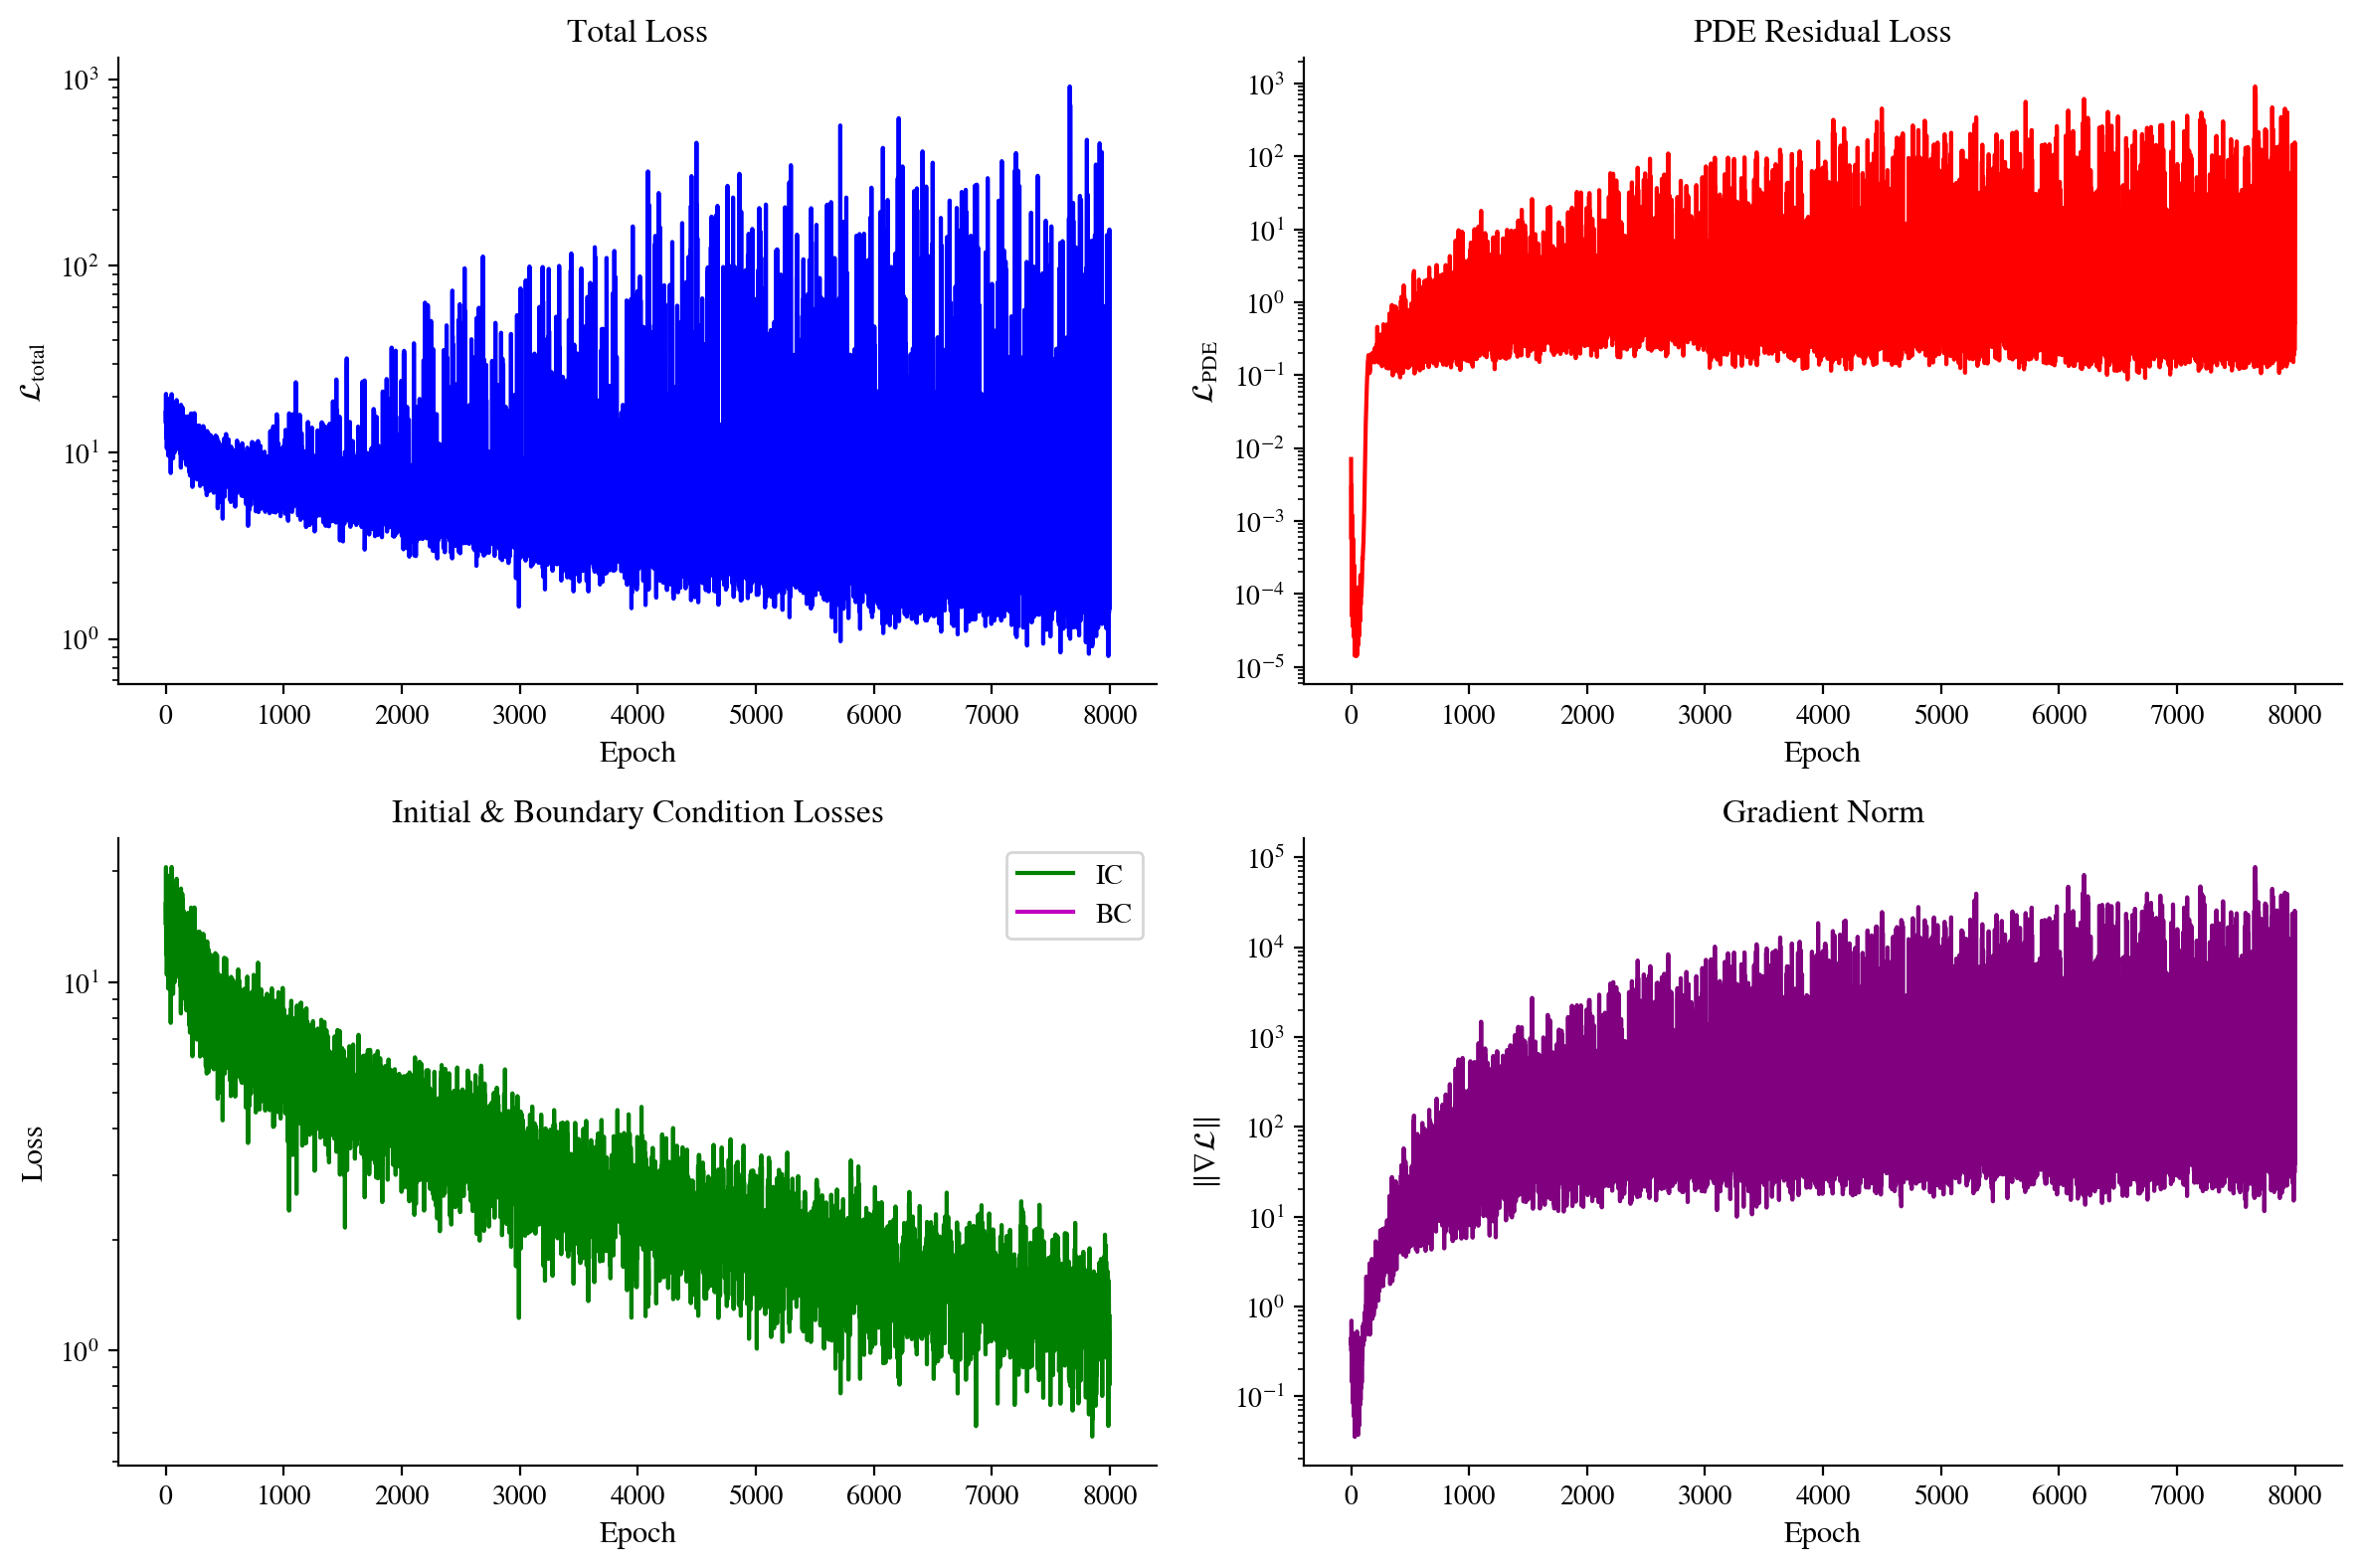


Final Losses:
  Total:  1.473174e+00
  PDE:    2.331498e-01
  IC:     1.239203e+00


In [7]:
# Visualize training history
fig = plot_training_history(history, figsize=(12, 8))
plt.show()

print(f"\nFinal Losses:")
print(f"  Total:  {history['loss_total'][-1]:.6e}")
print(f"  PDE:    {history['loss_pde'][-1]:.6e}")
print(f"  IC:     {history['loss_ic'][-1]:.6e}")

## Part 3: Results & Validation

### 3.1 Error Metrics

We evaluate the PINN approximation quality using:
- **L² error**: $\|p_\theta - p_{\text{true}}\|_{L^2}$
- **L∞ error**: $\max |p_\theta - p_{\text{true}}|$
- **Relative L² error**: $\frac{\|p_\theta - p_{\text{true}}\|_{L^2}}{\|p_{\text{true}}\|_{L^2}}$

In [8]:
# Generate test points uniformly in domain
n_test = 5000
x_test = torch.rand(n_test, spatial_dim, device=device) * (x_max - x_min) + x_min
t_test = torch.rand(n_test, 1, device=device) * (t_max - 0.01) + 0.01  

with torch.no_grad():
    inputs = torch.cat([x_test, t_test], dim=-1)
    p_pred = network(inputs)
    p_true = equation.analytical_solution(x_test, t_test)

# Compute errors
abs_error = torch.abs(p_pred - p_true)
rel_error = abs_error / (p_true + 1e-10)

l2_error = torch.sqrt(torch.mean(abs_error**2)).item()
linf_error = torch.max(abs_error).item()
rel_l2 = l2_error / torch.sqrt(torch.mean(p_true**2)).item()

print(f"\nError Metrics ({n_test} test points):")
print(f"  L² error:          {l2_error:.6e}")
print(f"  Relative L² error: {rel_l2:.4%}")
print(f"  L∞ error:          {linf_error:.6e}")


Error Metrics (5000 test points):
  L² error:          4.523553e-02
  Relative L² error: 3.8671%
  L∞ error:          8.279438e-01


### 3.2 Density Evolution

We visualize the learned density $p(x,t)$ at multiple time points and compare with the analytical Gaussian solution.

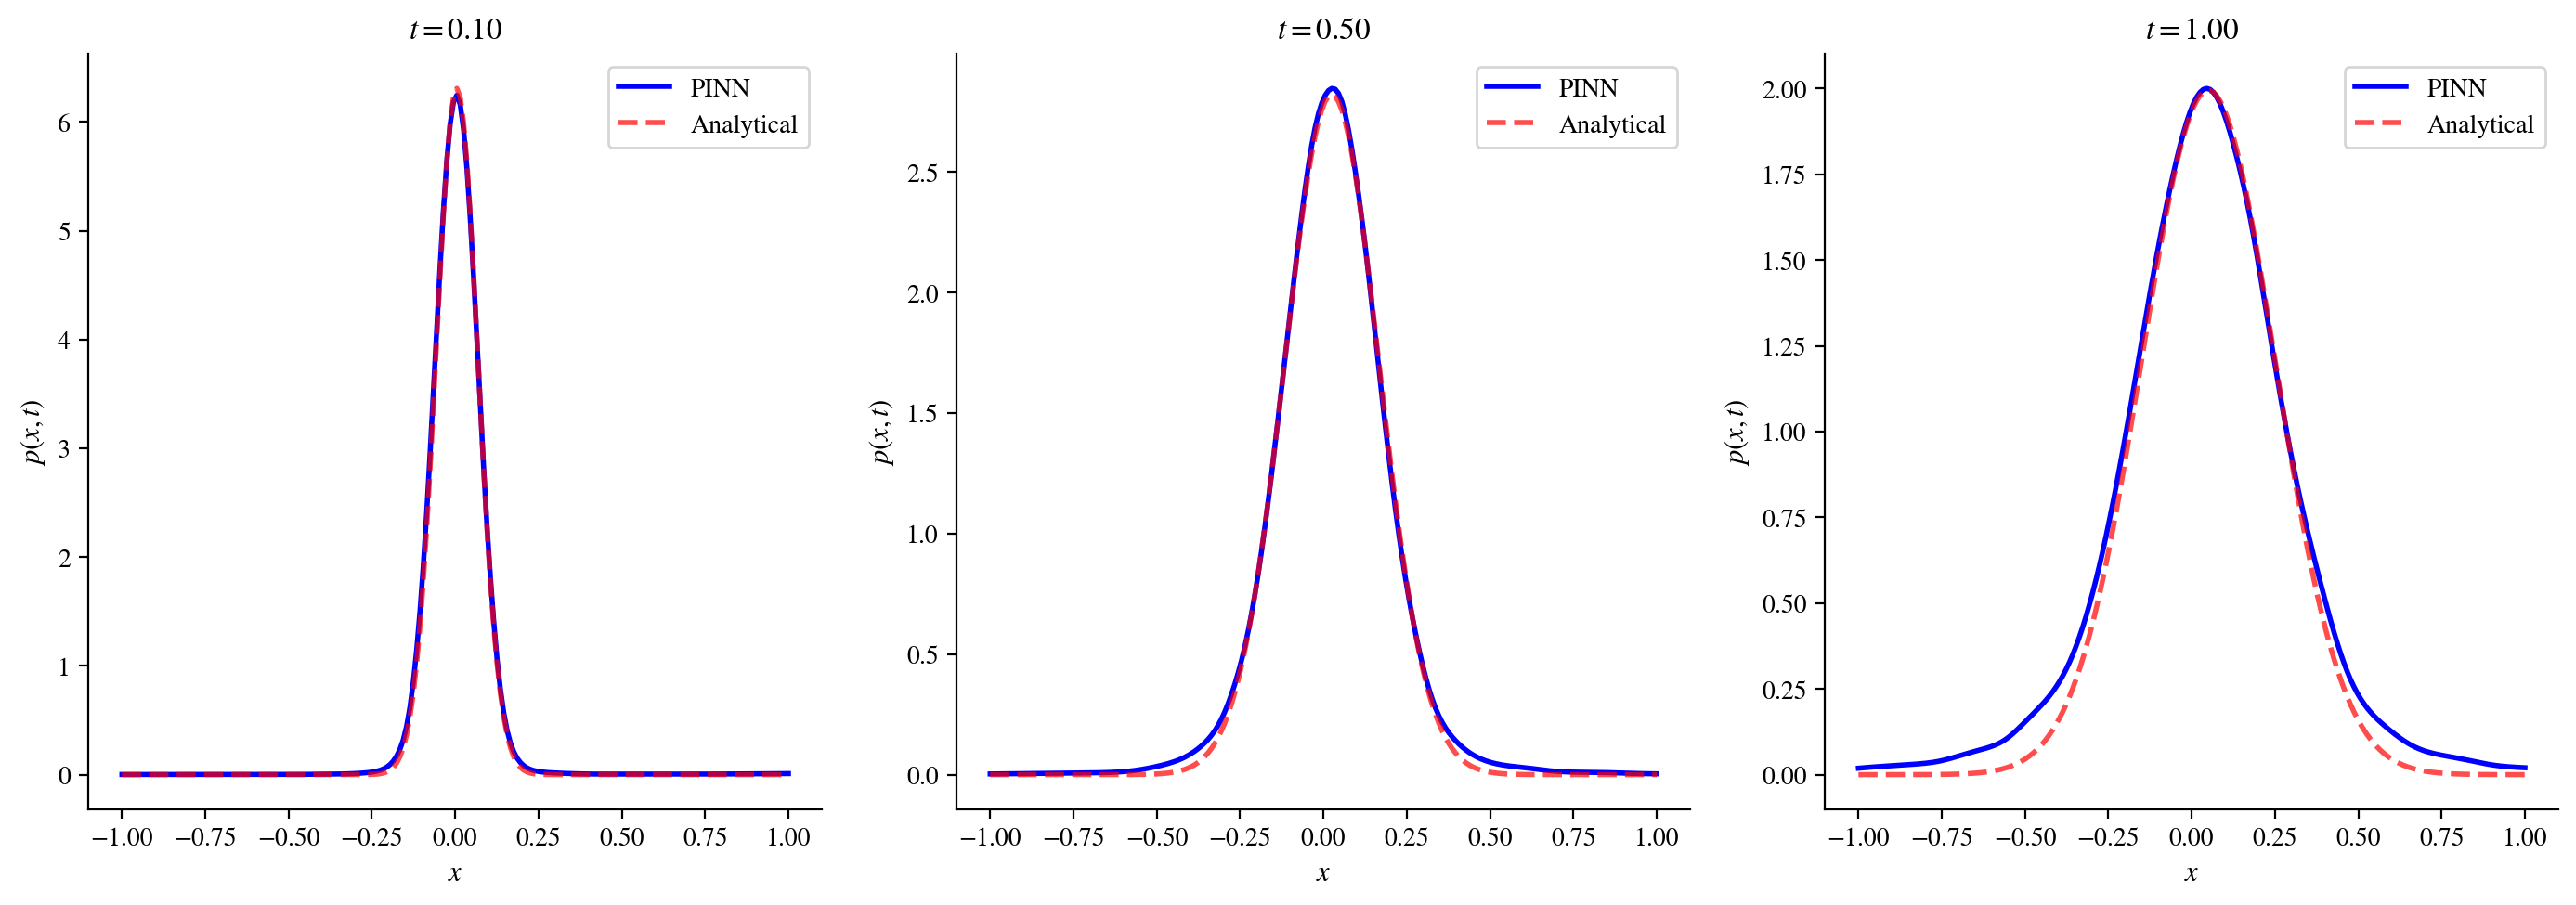

In [9]:
# Plot density evolution at multiple time points
fig = plot_density_evolution(
    network=network,
    spatial_dim=spatial_dim,
    x_range=(x_min, x_max),
    time_points=[0.1, 0.5, 1.0],
    analytical_solution=equation.analytical_solution,
    dim=0,  # Vary first dimension (for nD, fix others at 0)
    num_points=200,
    device=device,
    figsize=(14, 5)
)
plt.show()

### 3.3 Score Function Analysis

The score function $s(x,t) = \nabla_x \log p(x,t)$ is extracted from the learned density for use in score-based diffusion models.

**Computation**: Given the trained network $p_\theta(x,t)$, the score is:
$$
s_\theta(x,t) = \nabla_x \log p_\theta(x,t) = \frac{\nabla_x p_\theta(x,t)}{p_\theta(x,t)}
$$
computed via automatic differentiation.

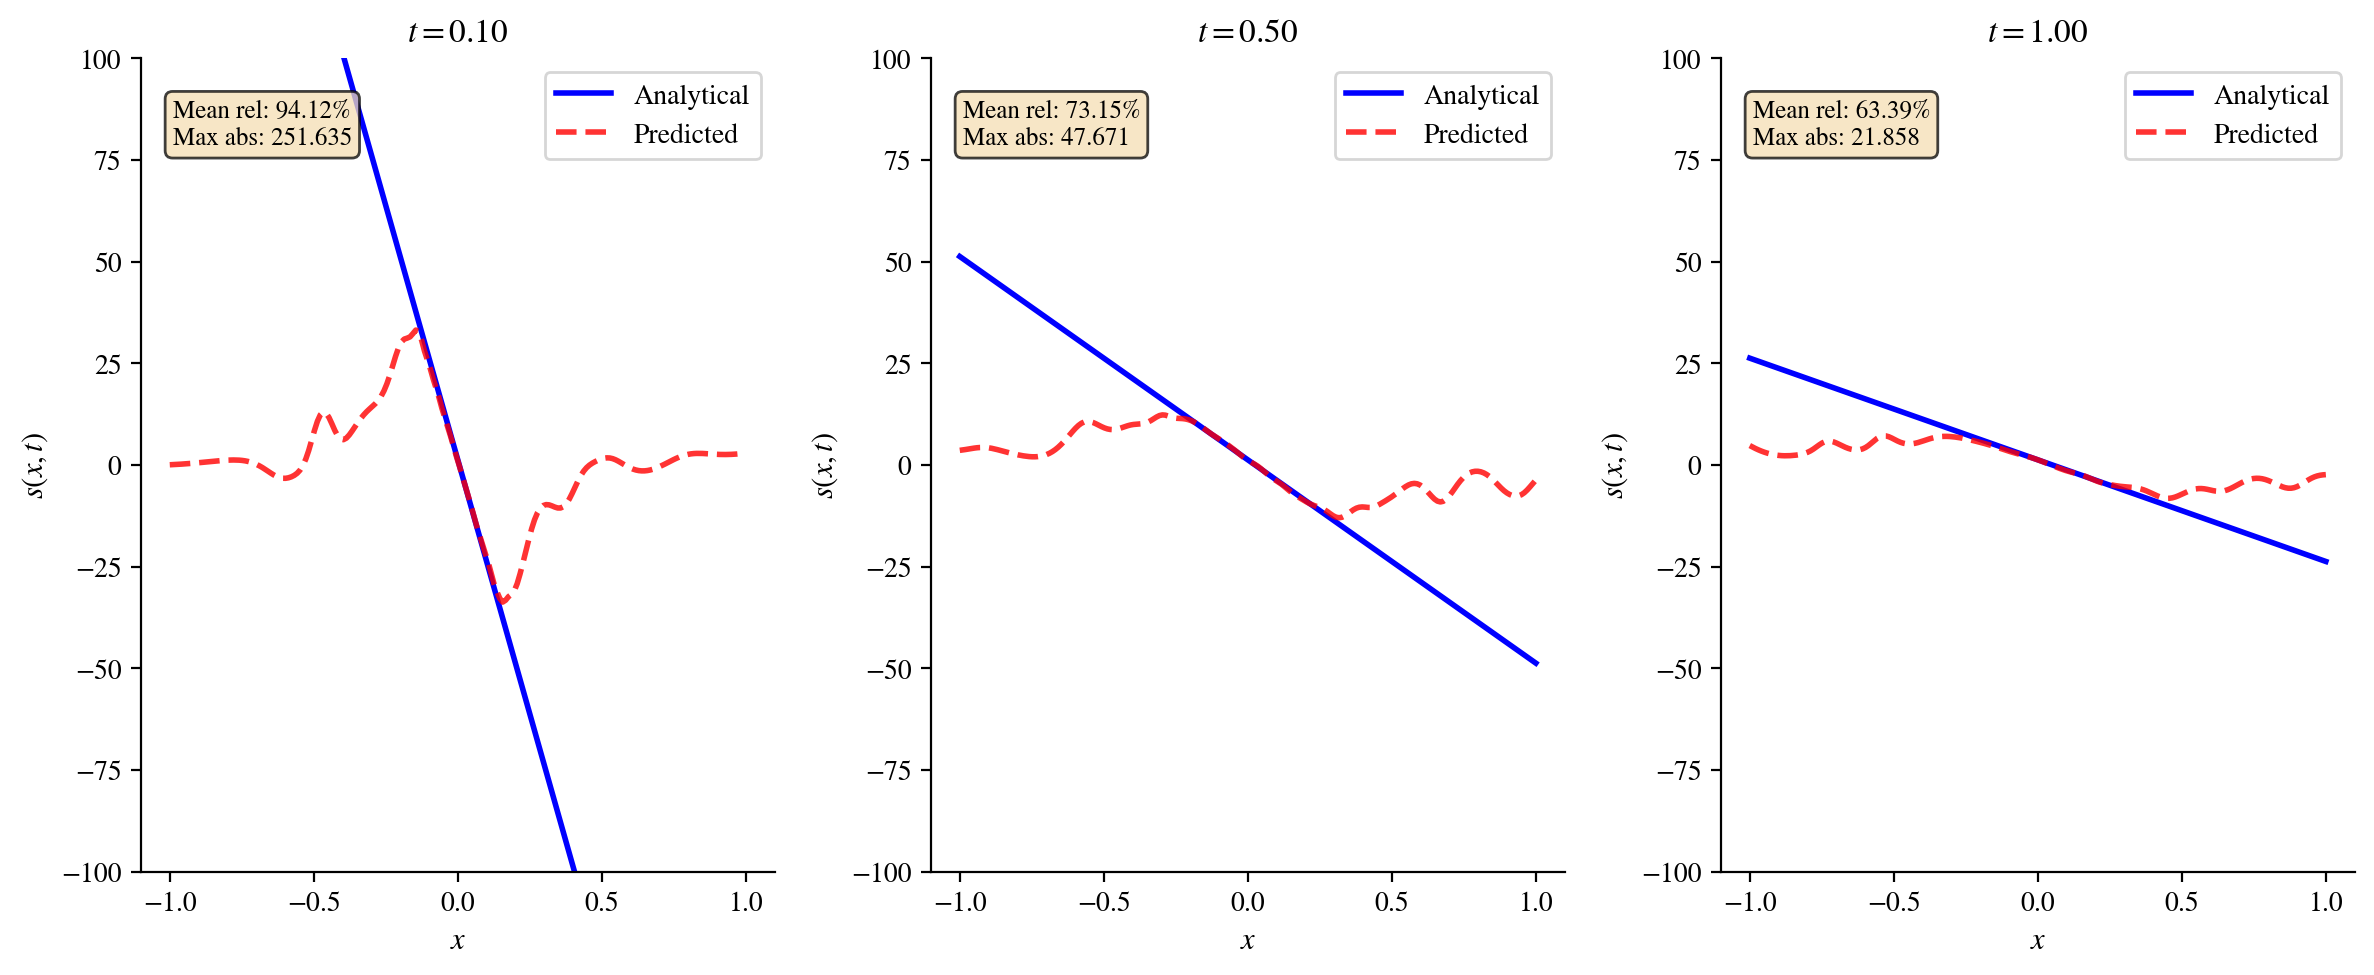

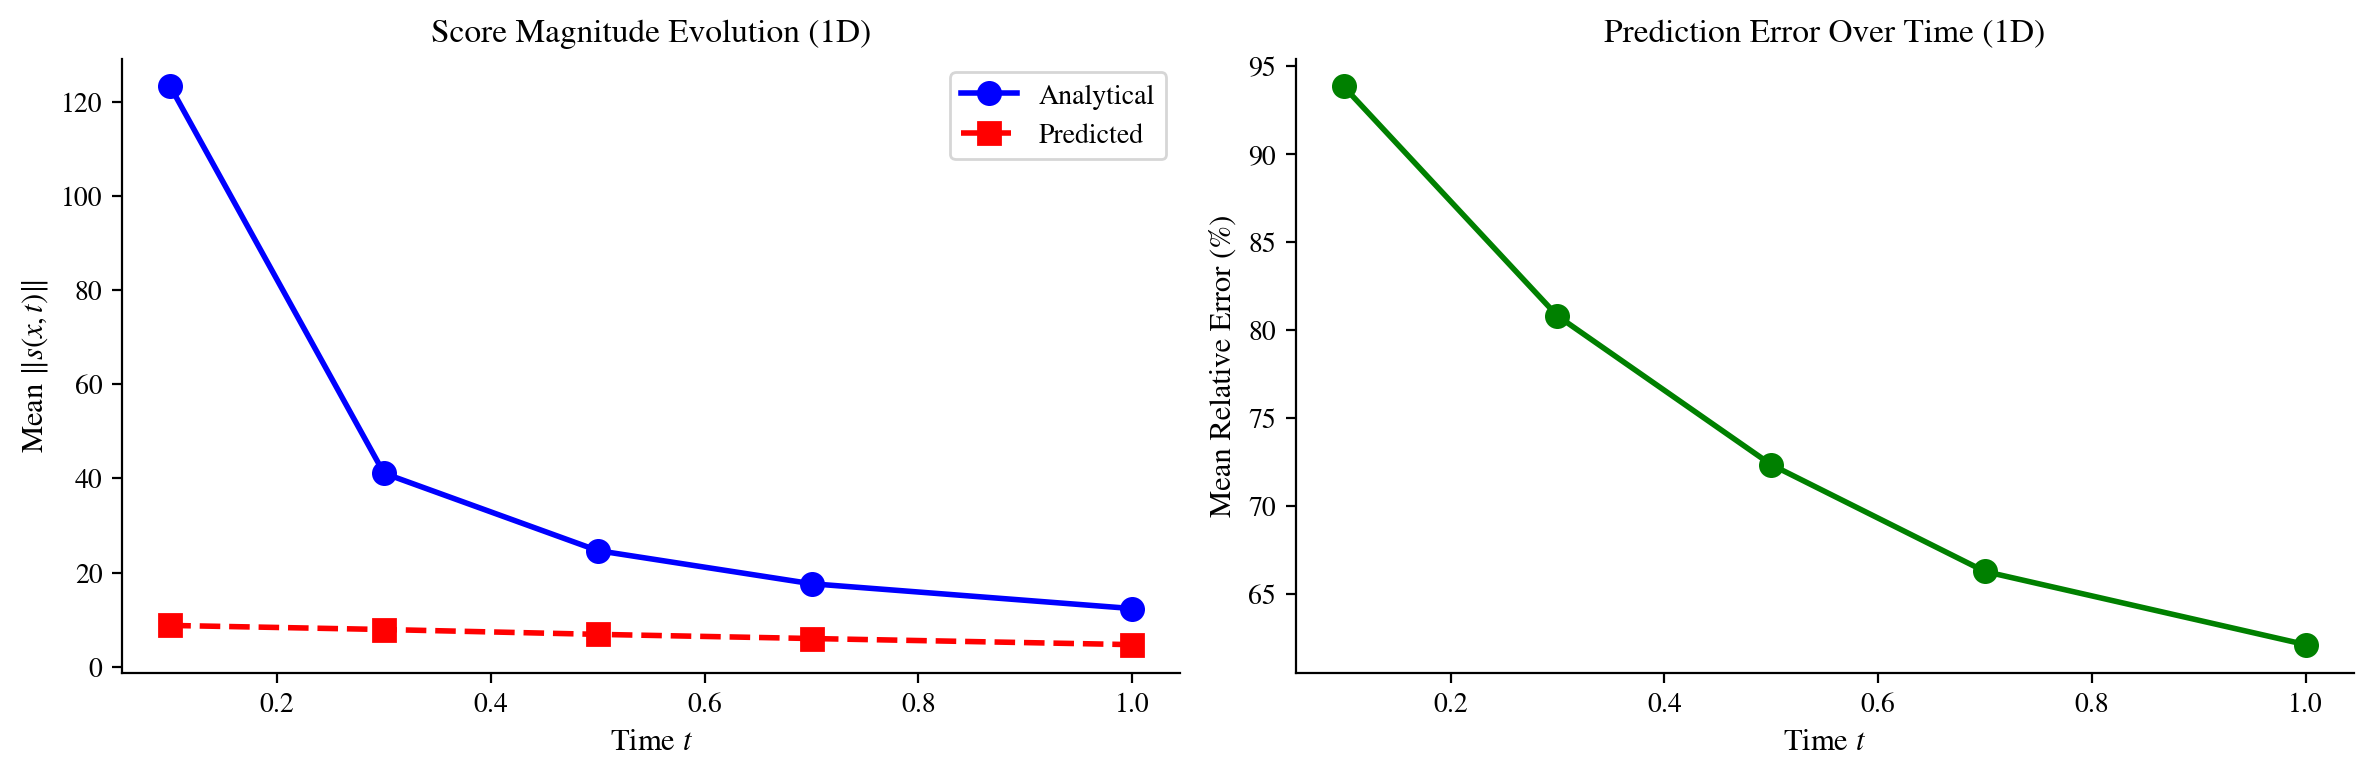

In [10]:
# Extract score function from trained density network
score_extractor = ScoreExtractor(
    network=network, 
    device=device, 
    epsilon=0,
    spatial_dim=spatial_dim
)

# Plot score field evolution
fig = plot_score_field(
    solver=score_extractor,
    equation=equation,
    x_range=(x_min, x_max),
    y_range=(-100,100),
    time_points=[0.1, 0.5, 1.0],
    dim=0,
    fixed_values=None,          
    num_points=200,
    device=device,
    figsize=(12, 5)
)
plt.show()

# Score magnitude analysis over time
fig = plot_score_magnitude_analysis(
    solver=score_extractor,
    equation=equation,
    eval_times=[0.1, 0.3, 0.5, 0.7, 1.0],
    n_samples=1000,
    x_range=(x_min, x_max),
    device=device,
    figsize=(12, 4)
)
plt.show()

---

## References

1. Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. *Journal of Computational Physics*.

2. Song, Y., Sohl-Dickstein, J., Kingma, D. P., Kumar, A., Ermon, S., & Poole, B. (2021). Score-based generative modeling through stochastic differential equations. *ICLR 2021*. https://arxiv.org/abs/2011.13456